In [1]:
from core import *
from core_mps import *
from quantum_plots import *
from mps.state import MPS, CanonicalMPS
from mps.mpo import MPO, MPOList
from mps.qft import qft_mpo, qft_flip, qft, iqft

Global props:
fontsizes :
     tiny :  6
     scriptsize :  8
     footnotesize :  9
     small :  10
     normalsize :  11
     large :  12
     Large :  14
     LARGE :  17
     huge :  20
     Huge :  25
colors :
     quantumviolet :  #53257F
     quantumgray :  #555555


## Quantum Fourier Transform

We want to analyze the performance of the QFT on the states that we have been studying.

In [2]:
def twoscomplement(L, **kwdargs):
    A0 = np.zeros((1,2,2,2))
    A0[0,0,0,0] = 1.
    A0[0,1,1,1] = 1.
    A = np.zeros((2,2,2,2))
    A[0,0,0,0] = 1.
    A[0,1,1,0] = 1.
    A[1,1,0,1] = 1.
    A[1,0,1,1] = 1.
    Aend = A[:,:,:,[0]] + A[:,:,:,[1]]
    return MPO([A0] + [A]*(L-2) + [Aend], **kwdargs)

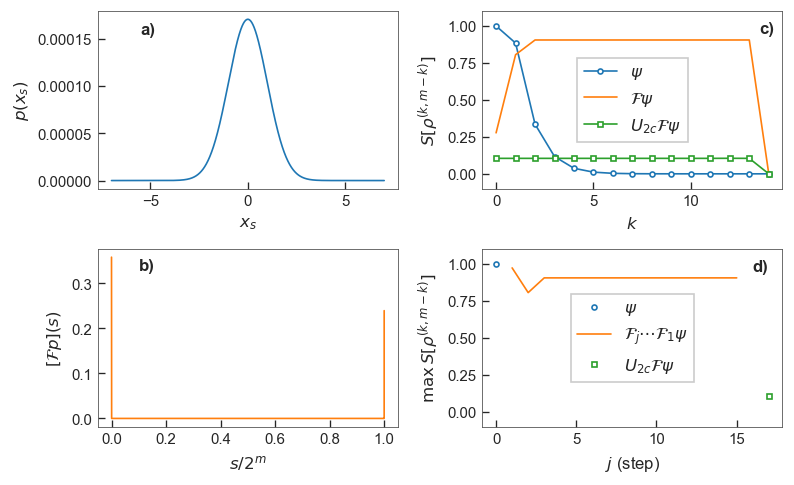

In [3]:
def study_qft_entropies(σ=1.0, M=15):
    
    ψ, x = Gaussian_GR(M, σ=σ, μ=0, a=-7, b=7)
    ψmps = MPS.fromvector(ψ, [2]*M)
    F = qft_mpo(M, simplify=True, normalize=True)
    S = [all_entropies(ψmps)]
    for mpo in F.mpos:
        ψmps = mpo.apply(ψmps)
        S.append(all_entropies(ψmps))
    Fψmps = qft_flip(ψmps)
    F2ψmps = twoscomplement(M, simplify=True, normalize=True).apply(Fψmps)
    S.append(all_entropies(F2ψmps))
    
    fig = plot_setup(aspect_ratio=1/1.62, wide=True)
    ax = fig.add_subplot(2,2,4)
    Smax = [max(s) for s in S]
    ax.plot(0, Smax[0], 'o', mfc='w', label='$\\psi$')
    ax.plot(np.arange(1,M+1), Smax[1:-1], '-', mfc='w', label='$\\mathcal{F}_j\\cdots\\mathcal{F}_1\\psi$')
    ax.plot(M+2, Smax[-1], 's', mfc='w', label='$U_{2c}\\mathcal{F}\\psi$')
    ax.set_ylabel('$\\max\\,S[\\rho^{(k,m-k)}]$')
    ax.set_xlabel('$j$ (step)')
    ax.set_ylim([-0.1,1.1])
    ax.legend(frameon=True,loc='center')
    ax.text(16,0.95,'d)', fontweight='bold')
    
    ax = fig.add_subplot(2,2,1)
    ax.plot(x, np.abs(ψ)**2)
    ax.set_xlabel('$x_s$')
    ax.set_ylabel('$p(x_s)$')
    ax.text(-5.5,0.000155,'a)',fontweight='bold')
    
    ax = fig.add_subplot(2,2,3)
    ax.plot(np.arange(2**M)/2**M, np.abs(Fψmps.tovector())**2, color=color2)
    ax.set_xlabel('$s/2^m$')
    ax.set_ylabel('$[\\mathcal{F}p](s)$')
    ax.text(0.1,0.33,'b)',fontweight='bold')
    
    ax = fig.add_subplot(2,2,2)
    ax.plot(S[0], '-o', mfc='w', label='$\\psi$')
    ax.plot(S[-2], '-', label='$\\mathcal{F}\\psi$')
    ax.plot(S[-1], '-s', mfc='w', label='$U_{2c}\\mathcal{F}\\psi$')
    ax.set_ylim([-0.1,1.1])
    ax.set_xlabel('$k$')
    ax.set_ylabel('$S[\\rho^{(k,m-k)}]$')
    ax.text(13.5,0.95,'c)', fontweight='bold')
    ax.legend(loc='center')
    
    plt.tight_layout()
    plt.savefig('../fig-QFT-entropy.pdf')

study_qft_entropies()

## Quantum Fourier interpolation

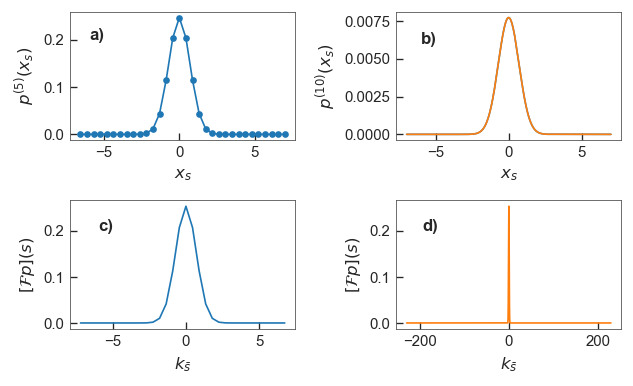

In [4]:
def qft_interpolation(σ=1.0, M0=5, Mf=10, a=None, b=None):
    
    if b is None:
        b=-7*σ
    if a is None:
        a=-b
    x0 = np.linspace(a, b, 2**M0+1)[:-1]
    xf = np.linspace(a, b, 2**Mf+1)[:-1]
    ψ0 = np.exp(-x0**2/(2*σ**2)); ψ0 /= np.linalg.norm(ψ0)
    ψf = np.exp(-xf**2/(2*σ**2)); ψf /= np.linalg.norm(ψf)
    
    ψ0mps = MPS.fromvector(ψ0, [2]*M0)
    U2c = twoscomplement(M0, simplify=True, normalize=True)
    Fψ0mps = U2c.apply(qft_flip(qft(ψ0mps)))
    #
    # Extend the state with zero qubits
    χ = Fψ0mps[0].shape[-1]
    A = np.zeros((χ,2,χ))
    for i in range(χ):
        A[i,0,i] = 1.0
    tensors = [Fψ0mps[0]]+[A]*(Mf-M0)+Fψ0mps[1:]
    Fψfmps = MPS(tensors)
    #
    # Undo Fourier transform
    U2c = twoscomplement(Mf, simplify=True, normalize=True)
    ψfmps = qft_flip(iqft(U2c.apply(Fψfmps)))
    ψfint = ψfmps.tovector()
    ψfint /= np.linalg.norm(ψfint)
    xint = xf;
    
    fig = plot_setup(aspect_ratio=1/1.62, width_ratio=0.8, wide=True)
    ax = fig.add_subplot(2,2,1)
    ax.plot(x0, np.abs(ψ0)**2/np.sum(np.abs(ψ0)**2), '-o')
    ax.set_xlabel('$x_s$')
    ax.set_ylabel('$p^{(5)}(x_s)$')
    ax.text(-6,0.2,'a)',fontweight='bold')
    
    ax = fig.add_subplot(2,2,2)
    ax.plot(xint, np.abs(ψfint**2))
    ax.plot(xf, np.abs(ψf**2))
    ax.set_xlabel('$x_s$')
    ax.set_ylabel('$p^{(10)}(x_s)$')
    ax.text(-6,0.006,'b)',fontweight='bold')
    
    ax = fig.add_subplot(2,2,3)
    ξ0 = np.abs(Fψ0mps.tovector())**2
    k0 = np.arange(-2**(M0-1),2**(M0-1))*2*np.pi/(14*σ)
    ξ0 = np.concatenate((ξ0[2**M0-1:2**(M0-1)-1:-1],ξ0[0:2**(M0-1)]))
    ax.plot(k0, ξ0, color=color1)
    ax.set_xlabel('$k_{\\bar{s}}$')
    ax.set_ylabel('$[\\mathcal{F}p](s)$')
    ax.text(-6,0.2,'c)',fontweight='bold')
    
    ax = fig.add_subplot(2,2,4)
    ξf = np.abs(Fψfmps.tovector())**2
    kf = np.arange(-2**(Mf-1),2**(Mf-1))*2*np.pi/(14*σ)
    ξf = np.concatenate((ξf[2**Mf-1:2**(Mf-1)-1:-1],ξf[0:2**(Mf-1)]))
    ax.plot(kf, ξf, color=color2)
    ax.set_xlabel('$k_{\\bar{s}}$')
    ax.set_ylabel('$[\\mathcal{F}p](s)$')
    ax.text(-195,0.2,'d)',fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../fig-QFT-interpolation.pdf')
    plt.savefig('../fig-QFT-interpolation.svg')

qft_interpolation()

## Fokker-Planck spectral method

We can solve the Fokker-Planck equation in Fourier space. We need to realize that the differential operators are much easier in momentum space
$$\frac{\partial}{\partial x} e^{i k x} \sim k e^{i k x}.$$
Thanks to this, any differential equation with a generator $G(\partial_x)$ which is a function of the derivatives
$$\partial_t|\psi\rangle = G(\partial_x)|\psi\rangle$$
can be solved in Fourier space as
$$|\tilde\psi(t)\rangle = e^{G(i k)} |\tilde\psi(0)\rangle,$$
where $|\tilde\psi\rangle = \mathcal{F}|\psi\rangle$ is the Fourier transform of the state.

Since we are interested in the "laboratory" representation, not in the transformed state, we can write
$$|\psi(t)\rangle = \mathcal{F^{-1}} e^{G(ik)} \mathcal{F} |\psi(0)\rangle.$$

In practice things are a bit more complicated. We are working with finite discretized intervals $x_s\in[a,b],$ and the derivative $\partial_x$ does not have a trivial representation: we must approximate it.

First we have to remember that the discretization reads
$$x = a + s\,\delta{x},\; s=0,1,\ldots,2^{m}-1,$$
with discretization step
$$\delta{x} = \frac{b-a}{2^m} = \frac{L}{N}.$$
Associated to this discrete coordinate, we have the quasimomentum variable
$$q = \frac{2\pi}{L} s \in \frac{2\pi}{L}\times\{0,1,2\ldots, N-1\},$$
where once more $s$ denotes the states of the quantum register.

Note that this quasimomentum is not quite our 'k' coordinate. The quasimomentum $2\pi(N-1)/L$ effectively represents the negative momentum $k=-2\pi/L.$ More generally, we can associate to the binary numbers $s$ a real momentum
$$k = \frac{2\pi}{L} \times \bar{s}$$
where $\bar{s}$ is a positive or negative number that uses the [two's complement representation](https://en.wikipedia.org/wiki/Two%27s_complement) with $m$ bits of precision
$$\bar{s} = \left\{
\begin{array}{l}
\sum_{n=2}^m 2^{m-n}s_n, & s_1 = 0\\
-\sum_{n=2}^m 2^{m-n}(1-s_n) - 1, & s_1=1.
\end{array}\right.$$

We can write
$$\bar{s}=-s_1 + \sum_{n=2}^{m}2^{m-n} \left[ (1-s_1) s_n - s_1 (1-s_n)\right]
=-s_1 + \sum_{n=2}^{m}2^{m-n} \left[ s_n-s_1\right] $$

In [5]:
def c2(m, debug=True):
    alls = []
    for z in range(0,2**m):
        b = [(z >> i) & 1 for i in reversed(range(0,m))]
        s = sum(2**(m-i)*(b[i-1]-b[0]) for i in range(2,m+1)) - b[0]
        if debug:
            print(f'b={b}, s={s}')
        alls.append(s)
    return np.array(alls)
c2(4)

b=[0, 0, 0, 0], s=0
b=[0, 0, 0, 1], s=1
b=[0, 0, 1, 0], s=2
b=[0, 0, 1, 1], s=3
b=[0, 1, 0, 0], s=4
b=[0, 1, 0, 1], s=5
b=[0, 1, 1, 0], s=6
b=[0, 1, 1, 1], s=7
b=[1, 0, 0, 0], s=-8
b=[1, 0, 0, 1], s=-7
b=[1, 0, 1, 0], s=-6
b=[1, 0, 1, 1], s=-5
b=[1, 1, 0, 0], s=-4
b=[1, 1, 0, 1], s=-3
b=[1, 1, 1, 0], s=-2
b=[1, 1, 1, 1], s=-1


array([ 0,  1,  2,  3,  4,  5,  6,  7, -8, -7, -6, -5, -4, -3, -2, -1])

Using this, we can implement a unitary MPO that performs the exponentiation $\exp(c k)$ with any coefficient $c.$ This is an almost local operator
$$\exp(c k) = \exp(-c s_1) \prod_{n=2}^{m} \exp\left[c (1-s_1) 2^{m-n} s_n - c s_1 2^{m-n} (1-s_n)\right].$$

In [6]:
def mpo_expk(c, m, L, **kwdargs):
    """Implement exp(ck) for a register with 'm' qubits.
    
    Parameters
    ----------
    c        -- coefficient in the exponent
    m        -- size of quantum register
    **kwdargs-- extra arguments for MPO
    """
    c *= 2*np.pi/L
    A0 = np.zeros((1,2,2,2), dtype=type(c))
    A0[0,1,1,1] = np.exp(-c)
    A0[0,0,0,0] = 1.0
    
    out = [A0]
    for n in range(2,m+1):
        cn = c * 2**(m-n)
        A = np.zeros((2,2,2,2), dtype=type(c))
        A[0,1,1,0] = np.exp(cn)
        A[0,0,0,0] = 1.
        A[1,1,1,1] = 1.
        A[1,0,0,1] = np.exp(-cn)
        if n==m:
            A = A[:,:,:,[0]]+A[:,:,:,[1]]
        out.append(A)
    return MPO(out, **kwdargs)

We can test this with a simple Gaussian function and the displacement operator. We have the equation
$$\partial_t p(x,t) = -\mu \partial_x p(x,t).$$
This has a solution of the form
$$p(x,t) = p(x-\mu t,0),$$
and it can be solved in our representation using
$$p(x,t) = \mathcal{F}^{-1} e^{-i \mu k} \mathcal{F} p(x,t).$$

<x(0)> = 0.027451, <x(T)> = 1.031373


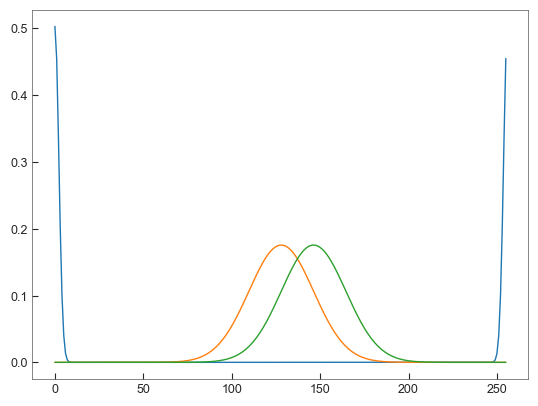

In [7]:
from mps.qft import qft, iqft, qft_flip
import matplotlib.pyplot as plt

def test_drift(T=1.0, μ=1, m=8, σ=1.0, a=None, b=None):
    if a is None:
        a = -7*σ
    if b is None:
        b = -a
    L = abs(b - a)
    x = np.linspace(a, b, 2**m)

    ψmps = GaussianMPS(m, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
    U = mpo_expk(-1j * T * μ, m, L, simplify=True)
    ξmps = qft_flip(qft(ψmps, simplify=True))
    ξmps = U.apply(ξmps)

    plt.plot(np.abs(ξmps.tovector()), label='$\\mathcal{F}ψ$')
    plt.plot(np.abs(ψmps.tovector()), label='$ψ$')
    ξmps = qft_flip(iqft(ξmps, simplify=True))
    plt.plot(np.abs(ξmps.tovector()), label='$\\mathcal{F}e^{-\\mu\\hat{k}}\\mathcal{F}ψ$')
    
    xm0 = np.sum(x * np.abs(ψmps.tovector()))/np.sum(np.abs(ψmps.tovector()))
    xmT = np.sum(x * np.abs(ξmps.tovector()))/np.sum(np.abs(ξmps.tovector()))
    print(f'<x(0)> = {xm0:5f}, <x(T)> = {xmT:5f}')
    
    plt.plot()

test_drift(m=8)

We can also implement $\exp(D k^2).$ For that, let us first study $k^2.$ Recall
$$k =\frac{2\pi}{L}\bar{s},$$
and
$$\bar{s}=-s_1\left[1 +  \sum_{n=2}^{m}2^{m-n} (1-s_n)\right]
+ (1-s_1) \sum_{n=2}^{m}2^{m-n} s_n$$

We realize that $s_1$ and $(1-s_1)$ are projectors and hence $s_1(1-s_1)=0.$ We can therefore write
$$\bar{s}^2=s_1\left[1 +  \sum_{n=2}^{m}2^{m-n} (1-s_n)\right]^2
+ (1-s_1) \left[\sum_{n=2}^{m}2^{m-n} s_n\right]^2.$$
This can be written in QUBO form
$$\bar{s}^2=\sum_i Q_{ij}s_i s_j,$$
but the coefficients in $Q$ are negative and positive, and pretty large, which causes problems.

We realize that there is a unitary operation that implements two's complement:
$$U|s_1,s_n\rangle = |s_1,s_1\oplus s_n\rangle =|s_1,s_n'\rangle,$$
with which the expression for $\bar{s}^2$ radically changes:
$$\bar{s}=-s_1\left[1 + \sum_{n=2}^{m}2^{m-n} s_n \right] + (1-s_1) \sum_{n=2}^{m}2^{m-n} s_n$$
$$\bar{s}^2 = s_1 \left[1 + \sum_{n=2}^m 2^{m-n}s_n'\right]^2 + (1-s_1)\left[\sum_{n=2}^m 2^{m-n}s_n'\right]^2.$$
This new formulation now has $Q_{ij}'\geq 0.$

It is convenient to rewrite
$$\bar{s}^2 = s_1 + 2s_1 S + S^2$$
with
$$S = \sum_{n=2}^{m} 2^{m-n}s_n'.$$
Then we have
$$Q_{1,1} = 1,\; Q_{1,n\geq 2} = 2^{m-n} = Q_{n\geq 2,1},\; Q_{n\geq 2,n'\geq 2} = 2^{2m-n-n'}.$$

In [8]:
def QUBOs2(m):
    if False:
        powers = 2**(m-np.arange(2,m+1))
        Q = np.block([[np.ones((1,1)), powers.reshape(1,m-1)],
                      [powers.reshape(m-1,1), np.outer(powers,powers)]])
    else:
        h = [1] + [2**(m-n) for n in range(2,m+1)]
        Q = np.outer(h, h)
    return Q

We can implement the exponential of the QUBO operator
$$e^{\beta H} = U_{2comp} e^{\beta \sum_{ij} h_i h_j s_i s_j} U_{2comp},$$
where $U_{2comp}$ is the two's complement operator.

In [9]:
def QUBOMPO(Q, β=1, **kwdargs):
    L = len(Q)
    Q = β*Q

    def tensor(u,v):
        A = np.zeros((2,2,2,2), dtype=np.float64)
        if v == u:
            A[1,1,1,1] = np.exp(Q[u,u])
            A[0,0,0,0] = 1.
        else:
            A[1,1,1,1] = np.exp(Q[u,v])
            A[1,0,0,1] = 1.
            A[0,1,1,0] = 1.
            A[0,0,0,0] = 1.
        if v==L-1:
            A = np.einsum('aijb->aij', A).reshape((A.shape[0],2,2,1))
        if v==0:
            A = np.einsum('aijb->ijb', A).reshape((1,2,2,A.shape[-1]))
        return A

    U2comp = twoscomplement(L, **kwdargs)
    return MPOList([U2comp] +
                   [MPO([tensor(u,v) for v in range(L)], **kwdargs)
                    for u in range(L)] +
                   [U2comp])

And use this to implement the diffusion operator $\exp(Dk^2).$

In [10]:
from mps.qft import qft, iqft, qft_flip
import matplotlib.pyplot as plt

def QFTFokkerPlanck(T=1.0, steps=10, D=0.2, μ=0.1, m=10, σ=1.0, a=None, b=None, filename=None):
    if b is None:
        b = 7*σ
    if a is None:
        a = -b
    L = abs(b - a)
    x = np.linspace(a, b, 2**m)
    times = np.linspace(0, T, steps)
    δt = times[1]

    ψmps = GaussianMPS(m, σ, a=a, b=b, GR=False, canonical=True, normalize=True)
    Uμ = mpo_expk(-1j * δt * μ, m, L, simplify=True)
    UD = QUBOMPO(QUBOs2(m), β=-δt*D*(2*np.pi/L)**2, simplify=True)
    
    ψ = [ψmps.tovector()]
    error = [0.]
    for t in times[1:]:
        ψmps = qft_flip(qft(ψmps, simplify=True));
        ψmps = UD.apply(Uμ.apply(ψmps))
        ψmps = qft_flip(iqft(ψmps, simplify=True))
        error.append(ψmps.error())
        ψ.append(ψmps.tovector())
        theψ = np.abs(ψ[-1])
        theψ /= np.sum(theψ)
        xm = np.sum(x * theψ)
        x2m = np.sum(x*x*theψ)
        σ2m = x2m - xm**2
        print(f't={t:4}, <x>={xm:5}, <σ2>={σ2m:5}, err={error[-1]}')
        plt.plot(np.abs(ψ[-1]))
    ψ = np.array(ψ)
    if filename is not None:
        with open(filename,'wb') as f:
            pickle.dump((ψ, x, times, error, D, μ, b), f)
    return ψ, x, times, error

if not os.path.exists('data/fokker-planck-2d-b.pkl'):
    #mps.tools.DEBUG = False
    QFTFokkerPlanck(m=10, σ=1.0, T=30., steps=100, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-b.pkl');

In [11]:
if not os.path.exists('data/fokker-planck-2d-c.pkl'):
    QFTFokkerPlanck(m=14, σ=1.0, T=30., steps=100, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-c.pkl');

In [12]:
if not os.path.exists('data/fokker-planck-2d-b.pkl'):
    #mps.tools.DEBUG = False
    #QFTFokkerPlanck(m=10, σ=1.0, T=1., steps=10, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-b.pkl');
    QFTFokkerPlanck(m=10, σ=1.0, T=30., steps=10, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-d.pkl');

In [13]:
if not os.path.exists('data/fokker-planck-2d-c.pkl'):
    QFTFokkerPlanck(m=14, σ=1.0, T=30., steps=10, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-e.pkl');